In [1]:
import numpy as np
import scipy 

Text to explain something

$ x^2+5=0 $


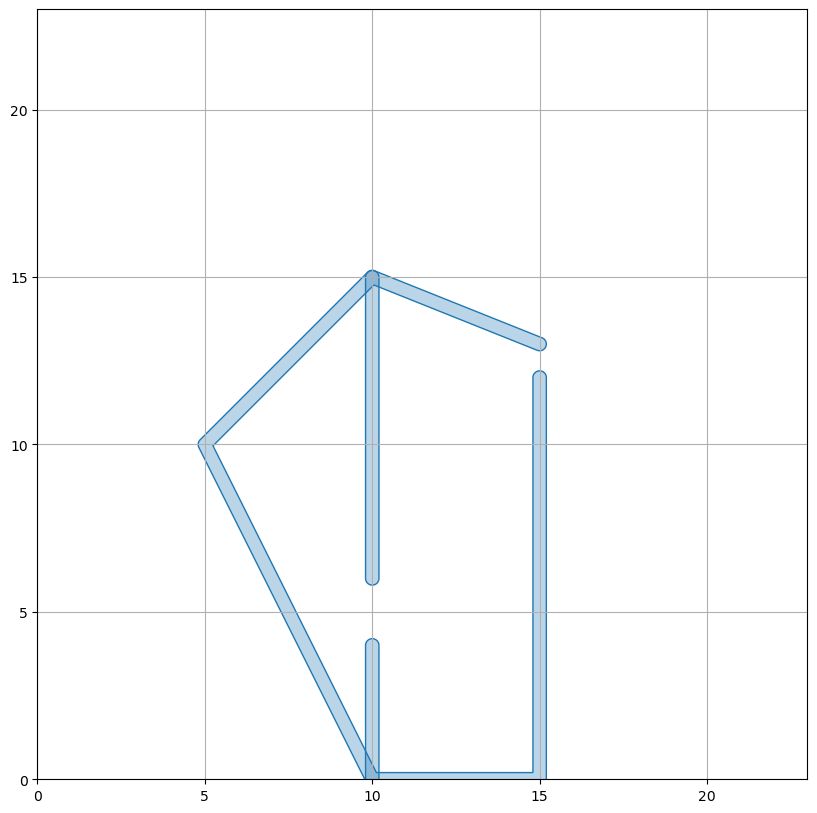

In [2]:
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, LineString
from shapely import plotting

MedField1 = dict()
MedField1["obs1"] = LineString([(15,13), (10,15), (5,10), (10,0), (15,0), (15,12) ]).buffer(0.2)
MedField1["obs2"] = LineString([(10,0), (10,4) ]).buffer(0.2)
MedField1["obs3"] = LineString([(10,15), (10,6) ]).buffer(0.2)

def drawScene(content, limits=[[0,23],[0,23]], figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    for key, value in content.items():
        plotting.plot_polygon(value, add_points=False)
        

drawScene(MedField1, figsize=(10,10))